In [1]:
import warnings
import numpy as np 
import pandas as pd 
import seaborn as sns 
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)


In [3]:
train = pd.read_csv('./application_train.csv')
test = pd.read_csv('./application_test.csv')
previous_application = pd.read_csv('./previous_application.csv')

In [4]:
train = train[train['CODE_GENDER'] != 'XNA']

In [5]:
bureau = pd.read_csv('./bureau.csv')
bureau_balance = pd.read_csv('./bureau_balance.csv')
pos_cash_balance = pd.read_csv('./POS_CASH_balance.csv')
credit_card_balance = pd.read_csv('./credit_card_balance.csv')
installments_payments = pd.read_csv('./installments_payments.csv')


In [6]:
import pandas as pd
import numpy as np
import multiprocessing
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import gc
from time import time
import datetime
import sys, random
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
warnings.simplefilter('ignore')
sns.set()
%matplotlib inline


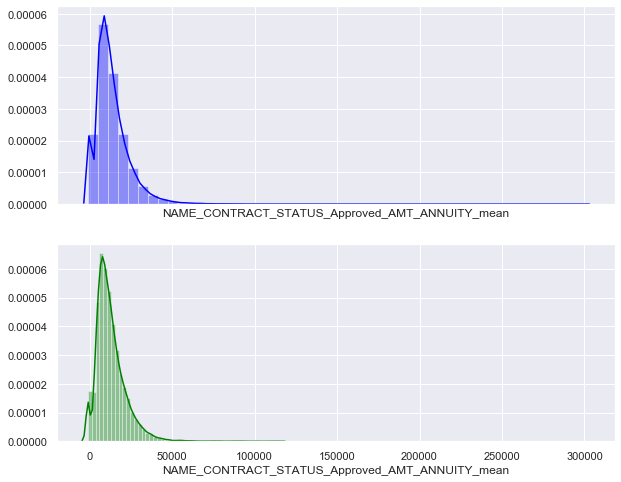

In [97]:
fig, axs = plt.subplots(nrows=2,ncols=1, figsize=(10,8), sharex=True)

sns.distplot(train.loc[train['TARGET'] == 0].NAME_CONTRACT_STATUS_Approved_AMT_ANNUITY_mean, color='blue', kde=True, ax=axs[0])
sns.distplot(train.loc[train['TARGET'] == 1].NAME_CONTRACT_STATUS_Approved_AMT_ANNUITY_mean, color='green', kde=True, ax=axs[1])

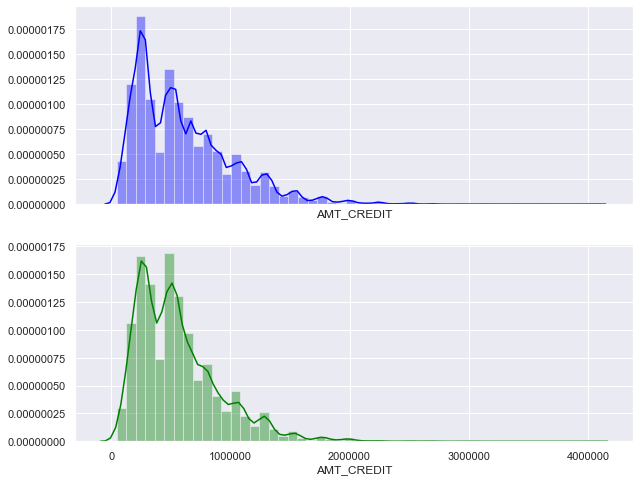

In [147]:
fig, axs = plt.subplots(nrows=2,ncols=1, figsize=(10,8), sharex=True)

sns.distplot(train.loc[train['TARGET'] == 0].AMT_CREDIT, color='blue', kde=True, ax=axs[0])
sns.distplot(train.loc[train['TARGET'] == 1].AMT_CREDIT, color='green', kde=True, ax=axs[1])

In [7]:
concat_application = pd.concat([train, test]).reset_index(drop=True)

In [8]:
concat_application.shape

(356251, 122)

In [9]:
app_categorical_columns = []
for c in concat_application.columns:
    if concat_application[c].dtype == object:
        print(c)
        app_categorical_columns.append(c)
        
for col in app_categorical_columns:
    le = LabelEncoder()
    le.fit(concat_application[col].values.reshape(-1, 1).astype('str'))
    concat_application[col] = le.transform(concat_application[col].values.reshape(-1, 1).astype('str'))


CODE_GENDER
EMERGENCYSTATE_MODE
FLAG_OWN_CAR
FLAG_OWN_REALTY
FONDKAPREMONT_MODE
HOUSETYPE_MODE
NAME_CONTRACT_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
NAME_INCOME_TYPE
NAME_TYPE_SUITE
OCCUPATION_TYPE
ORGANIZATION_TYPE
WALLSMATERIAL_MODE
WEEKDAY_APPR_PROCESS_START


In [10]:
def one_hot_encoder(df, column=None, nan_as_category=False):
    original_columns = list(df.columns)
    
    categorical_columns = []
    if not column:
        for c in df.columns:
            if df[c].dtype == object:
                print(c)
                categorical_columns.append(c)
        
        df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
            
    else:
        df = pd.get_dummies(df, columns=[column], dummy_na=nan_as_category)
    categorical_columns = [c for c in df.columns if c not in original_columns]
    
    return df, categorical_columns


def aggregate(df, group_cols, agg_method):
    return df.groupby(group_cols).agg(agg_method).reset_index()





## previous application and installment (之前的貸款申請紀錄以及分期付款紀錄）

In [166]:
previous_application.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY',
       'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY',
       'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY',
       'RATE_INTEREST_PRIVILEGED', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE',
       'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE',
       'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE',
       'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY',
       'CNT_PAYMENT', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL'],
      dtype='object')

In [11]:
previous_application['credit_application_diff'] = previous_application['AMT_APPLICATION'] - previous_application['AMT_CREDIT']
previous_application['application_ratio'] = previous_application['AMT_APPLICATION'] / previous_application['AMT_CREDIT']
previous_application['application_credit_goods_ratio'] = previous_application['AMT_GOODS_PRICE'] / previous_application['AMT_CREDIT']
previous_application['application_credit_annuity_ratio'] = previous_application['AMT_CREDIT'] / previous_application['AMT_ANNUITY']

# interest_rate = principal×interest rate×time = total_payment / AMT_CREDIT
previous_application['total_payment'] = previous_application['AMT_ANNUITY'] * previous_application['CNT_PAYMENT']
previous_application['interest_rate'] = previous_application['total_payment'] / previous_application['AMT_CREDIT']

previous_application['SK_ID_CURR_COUNT'] = previous_application.groupby(['SK_ID_CURR'])['SK_ID_PREV'].transform('count')



In [12]:
# previous_application & installments_payments

previous_application, categorical_columns  = one_hot_encoder(previous_application)

NAME_CONTRACT_TYPE
WEEKDAY_APPR_PROCESS_START
FLAG_LAST_APPL_PER_CONTRACT
NAME_CASH_LOAN_PURPOSE
NAME_CONTRACT_STATUS
NAME_PAYMENT_TYPE
CODE_REJECT_REASON
NAME_TYPE_SUITE
NAME_CLIENT_TYPE
NAME_GOODS_CATEGORY
NAME_PORTFOLIO
NAME_PRODUCT_TYPE
CHANNEL_TYPE
NAME_SELLER_INDUSTRY
NAME_YIELD_GROUP
PRODUCT_COMBINATION


In [13]:
previous_application['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
previous_application['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
previous_application['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
previous_application['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
previous_application['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)

previous_application['DAYS_DIFF'] = -previous_application['DAYS_FIRST_DUE'] - previous_application['DAYS_LAST_DUE']
previous_application['DAYS_FIRST_DRAWING_DIFF'] = -previous_application['DAYS_FIRST_DUE'] - previous_application['DAYS_FIRST_DRAWING']






In [14]:
previous_application['DAYS_FIRST_DRAWING'] = np.abs(previous_application['DAYS_FIRST_DRAWING'] / 365)
previous_application['DAYS_FIRST_DUE'] = np.abs(previous_application['DAYS_FIRST_DUE'] / 365)
previous_application['DAYS_LAST_DUE_1ST_VERSION'] = np.abs(previous_application['DAYS_LAST_DUE_1ST_VERSION'] / 365)
previous_application['DAYS_LAST_DUE'] = np.abs(previous_application['DAYS_LAST_DUE'] / 365)
previous_application['DAYS_TERMINATION'] = np.abs(previous_application['DAYS_TERMINATION'] / 365)
previous_application['DAYS_DECISION'] = np.abs(previous_application['DAYS_DECISION'] / 365)
previous_application['DAYS_LAST_DUE_DIFF'] = previous_application['DAYS_LAST_DUE_1ST_VERSION'] - previous_application['DAYS_LAST_DUE']


In [15]:
contract_cols = [
    'NAME_CONTRACT_STATUS_Approved',
    'NAME_CONTRACT_STATUS_Canceled',
    'NAME_CONTRACT_STATUS_Refused',
    'NAME_CONTRACT_STATUS_Unused offer',
    'NAME_CONTRACT_TYPE_Consumer loans', 
    'NAME_CONTRACT_TYPE_Revolving loans'
]

agg_columns = {
    'AMT_ANNUITY': ['mean', 'max', 'min'],
    'AMT_APPLICATION': ['mean', 'max', 'min'],
    'AMT_ANNUITY': ['mean', 'max', 'min'],
    'AMT_CREDIT': ['mean', 'max', 'min'],
    'AMT_DOWN_PAYMENT': ['mean', 'max', 'min'],
    'AMT_GOODS_PRICE': ['mean', 'max', 'min'],
    'CNT_PAYMENT': ['mean', 'max', 'min'],
    'HOUR_APPR_PROCESS_START': ['mean', 'max', 'min'],
    'DAYS_DECISION': ['mean', 'max', 'min'],
    'DAYS_DIFF': ['mean', 'max', 'min'],
    'DAYS_FIRST_DRAWING': ['mean', 'max', 'min'],
    'DAYS_FIRST_DUE': ['mean', 'max', 'min'],
    'DAYS_LAST_DUE_1ST_VERSION': ['mean', 'max', 'min'],
    'DAYS_LAST_DUE': ['mean', 'max', 'min'],
    'DAYS_LAST_DUE_DIFF': ['mean', 'max', 'min'],
    'credit_application_diff': ['mean', 'max', 'min'],
    'application_ratio': ['mean', 'max', 'min'],
    'application_credit_goods_ratio': ['mean', 'max', 'min'],
    'application_credit_annuity_ratio': ['mean', 'max', 'min'],
    'total_payment': ['mean', 'max', 'min'],
    'interest_rate': ['mean', 'max', 'min']
}

merge_col = ['SK_ID_CURR', 'SK_ID_CURR_COUNT']
for col in contract_cols:
    print(col, sep=', ')
    df = previous_application[previous_application[col] == 1]
    df = aggregate(previous_application, group_cols=['SK_ID_CURR'], agg_method=agg_columns)
    df.columns = [c[0] if c[0] == 'SK_ID_CURR' else f'{col}_{c[0]}_{c[1]}' for c in df.columns.tolist()]
    merge_col.extend(list(df.columns[1:]))
    df.reset_index(drop=True)
    previous_application = pd.merge(left=previous_application, right=df, on='SK_ID_CURR', how='left')


NAME_CONTRACT_STATUS_Approved
NAME_CONTRACT_STATUS_Canceled
NAME_CONTRACT_STATUS_Refused
NAME_CONTRACT_TYPE_Consumer loans
NAME_CONTRACT_TYPE_Revolving loans


In [16]:
previous_application.shape

(1670214, 474)

In [17]:
previous_application = previous_application.drop_duplicates('SK_ID_CURR').reset_index(drop=True)
concat_application = pd.merge(left=concat_application, right=previous_application[merge_col], on='SK_ID_CURR', how='left')



In [176]:
merge_col

['SK_ID_CURR',
 'NAME_CONTRACT_STATUS_Approved_AMT_ANNUITY_mean',
 'NAME_CONTRACT_STATUS_Approved_AMT_ANNUITY_max',
 'NAME_CONTRACT_STATUS_Approved_AMT_ANNUITY_min',
 'NAME_CONTRACT_STATUS_Approved_AMT_APPLICATION_mean',
 'NAME_CONTRACT_STATUS_Approved_AMT_APPLICATION_max',
 'NAME_CONTRACT_STATUS_Approved_AMT_APPLICATION_min',
 'NAME_CONTRACT_STATUS_Approved_AMT_CREDIT_mean',
 'NAME_CONTRACT_STATUS_Approved_AMT_CREDIT_max',
 'NAME_CONTRACT_STATUS_Approved_AMT_CREDIT_min',
 'NAME_CONTRACT_STATUS_Approved_AMT_DOWN_PAYMENT_mean',
 'NAME_CONTRACT_STATUS_Approved_AMT_DOWN_PAYMENT_max',
 'NAME_CONTRACT_STATUS_Approved_AMT_DOWN_PAYMENT_min',
 'NAME_CONTRACT_STATUS_Approved_AMT_GOODS_PRICE_mean',
 'NAME_CONTRACT_STATUS_Approved_AMT_GOODS_PRICE_max',
 'NAME_CONTRACT_STATUS_Approved_AMT_GOODS_PRICE_min',
 'NAME_CONTRACT_STATUS_Approved_CNT_PAYMENT_mean',
 'NAME_CONTRACT_STATUS_Approved_CNT_PAYMENT_max',
 'NAME_CONTRACT_STATUS_Approved_CNT_PAYMENT_min',
 'NAME_CONTRACT_STATUS_Approved_HOUR_APPR_PROCESS_START_mean',
 'NAME_CONTRACT_STATUS_Approved_HOUR_APPR_PROCESS_START_max',
 'NAME_CONTRACT_STATUS_Approved_HOUR_APPR_PROCESS_START_min',
 'NAME_CONTRACT_STATUS_Approved_DAYS_DECISION_mean',
 'NAME_CONTRACT_STATUS_Approved_DAYS_DECISION_max',
 'NAME_CONTRACT_STATUS_Approved_DAYS_DECISION_min',
 'NAME_CONTRACT_STATUS_Approved_DAYS_DIFF_mean',
 'NAME_CONTRACT_STATUS_Approved_DAYS_DIFF_max',
 'NAME_CONTRACT_STATUS_Approved_DAYS_DIFF_min',
 'NAME_CONTRACT_STATUS_Approved_DAYS_FIRST_DRAWING_mean',
 'NAME_CONTRACT_STATUS_Approved_DAYS_FIRST_DRAWING_max',
 'NAME_CONTRACT_STATUS_Approved_DAYS_FIRST_DRAWING_min',
 'NAME_CONTRACT_STATUS_Approved_DAYS_FIRST_DUE_mean',
 'NAME_CONTRACT_STATUS_Approved_DAYS_FIRST_DUE_max',
 'NAME_CONTRACT_STATUS_Approved_DAYS_FIRST_DUE_min',
 'NAME_CONTRACT_STATUS_Approved_DAYS_LAST_DUE_1ST_VERSION_mean',
 'NAME_CONTRACT_STATUS_Approved_DAYS_LAST_DUE_1ST_VERSION_max',
 'NAME_CONTRACT_STATUS_Approved_DAYS_LAST_DUE_1ST_VERSION_min',
 'NAME_CONTRACT_STATUS_Approved_DAYS_LAST_DUE_mean',
 'NAME_CONTRACT_STATUS_Approved_DAYS_LAST_DUE_max',
 'NAME_CONTRACT_STATUS_Approved_DAYS_LAST_DUE_min',
 'NAME_CONTRACT_STATUS_Approved_DAYS_LAST_DUE_DIFF_mean',
 'NAME_CONTRACT_STATUS_Approved_DAYS_LAST_DUE_DIFF_max',
 'NAME_CONTRACT_STATUS_Approved_DAYS_LAST_DUE_DIFF_min',
 'NAME_CONTRACT_STATUS_Approved_credit_application_diff_mean',
 'NAME_CONTRACT_STATUS_Approved_credit_application_diff_max',
 'NAME_CONTRACT_STATUS_Approved_credit_application_diff_min',
 'NAME_CONTRACT_STATUS_Approved_application_ratio_mean',
 'NAME_CONTRACT_STATUS_Approved_application_ratio_max',
 'NAME_CONTRACT_STATUS_Approved_application_ratio_min',
 'NAME_CONTRACT_STATUS_Approved_application_credit_goods_ratio_mean',
 'NAME_CONTRACT_STATUS_Approved_application_credit_goods_ratio_max',
 'NAME_CONTRACT_STATUS_Approved_application_credit_goods_ratio_min',
 'NAME_CONTRACT_STATUS_Approved_application_credit_annuity_ratio_mean',
 'NAME_CONTRACT_STATUS_Approved_application_credit_annuity_ratio_max',
 'NAME_CONTRACT_STATUS_Approved_application_credit_annuity_ratio_min',
 'NAME_CONTRACT_STATUS_Approved_total_payment_mean',
 'NAME_CONTRACT_STATUS_Approved_total_payment_max',
 'NAME_CONTRACT_STATUS_Approved_total_payment_min',
 'NAME_CONTRACT_STATUS_Approved_interest_rate_mean',
 'NAME_CONTRACT_STATUS_Approved_interest_rate_max',
 'NAME_CONTRACT_STATUS_Approved_interest_rate_min',
 'NAME_CONTRACT_STATUS_Canceled_AMT_ANNUITY_mean',
 'NAME_CONTRACT_STATUS_Canceled_AMT_ANNUITY_max',
 'NAME_CONTRACT_STATUS_Canceled_AMT_ANNUITY_min',
 'NAME_CONTRACT_STATUS_Canceled_AMT_APPLICATION_mean',
 'NAME_CONTRACT_STATUS_Canceled_AMT_APPLICATION_max',
 'NAME_CONTRACT_STATUS_Canceled_AMT_APPLICATION_min',
 'NAME_CONTRACT_STATUS_Canceled_AMT_CREDIT_mean',
 'NAME_CONTRACT_STATUS_Canceled_AMT_CREDIT_max',
 'NAME_CONTRACT_STATUS_Canceled_AMT_CREDIT_min',
 'NAME_CONTRACT_STATUS_Canceled_AMT_DOWN_PAYMENT_mean',
 'NAME_CONTRACT_STATUS_Canceled_AMT_DOWN_PAYMENT_max',
 'NAME_CONTRACT_STATUS_Canceled_AMT

In [20]:
concat_application.shape

(356251, 423)

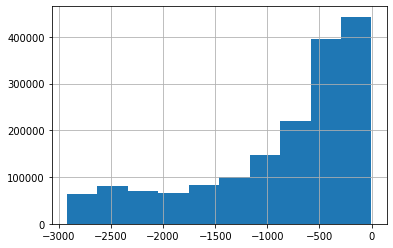

In [123]:
# DAYS_FIRST_DUE 相對於當前申請的申請日期，是第一個應為先前申請的日期
# DAYS_LAST_DUE 相對於當前申請的申請日期，即上一次申請的最後截止日期
# 相對於當前申請，何時做出關於先前申請的決定
# 相對於當前申請的申請日期為前一次申請的首次付款
previous_application['DAYS_DECISION'].hist()

In [48]:
installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [18]:
installments_payments['ins_payment_ratio'] = installments_payments['AMT_PAYMENT'] / installments_payments['AMT_INSTALMENT']
installments_payments['ins_payment_diff'] = installments_payments['AMT_INSTALMENT'] - installments_payments['AMT_PAYMENT']

installments_payments['day_past_due'] = installments_payments['DAYS_ENTRY_PAYMENT'] - installments_payments['DAYS_INSTALMENT']
installments_payments['delay_pay'] = installments_payments['day_past_due'].apply(lambda x: 1 if x > 0 else 0)


installments_payments['early_pay_7'] = installments_payments['day_past_due'].apply(lambda x: 1 if x <= -7 and x < 0 else 0)
installments_payments['early_pay_14'] = installments_payments['day_past_due'].apply(lambda x: 1 if x <= -14 and x < 8 else 0)
installments_payments['early_pay_30'] = installments_payments['day_past_due'].apply(lambda x: 1 if x <= -30 and x < 15 else 0)
installments_payments['early_pay_60'] = installments_payments['day_past_due'].apply(lambda x: 1 if x <= -60 and x < 31 else 0)


installments_payments['day_past_due_7'] = installments_payments['day_past_due'].apply(lambda x: 1 if x >= 7 else 0)
installments_payments['day_past_due_14'] = installments_payments['day_past_due'].apply(lambda x: 1 if x >= 14 else 0)
installments_payments['day_past_due_30'] = installments_payments['day_past_due'].apply(lambda x: 1 if x >= 30 else 0)
installments_payments['day_past_due_60'] = installments_payments['day_past_due'].apply(lambda x: 1 if x >= 60 else 0)




In [25]:
# installments_payments['last_payment_nums'] = installments_payments.groupby(['SK_ID_CURR'])['NUM_INSTALMENT_NUMBER'].last()

In [31]:
installments_payments[installments_payments['SK_ID_PREV'] == 1054186]

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,last_payment_nums
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.36,6948.36,NaN
47438,1054186,161674,1.0,2,-1300.0,-1307.0,6948.36,6948.36,NaN
138614,1054186,161674,1.0,8,-1120.0,-1175.0,6948.36,6948.36,31.0
216905,1054186,161674,1.0,12,-1000.0,-1033.0,6935.22,6935.22,6.0
425089,1054186,161674,1.0,3,-1270.0,-1275.0,6948.36,6948.36,4.0
577850,1054186,161674,1.0,1,-1330.0,-1338.0,6948.36,6948.36,NaN
1038640,1054186,161674,1.0,10,-1060.0,-1125.0,6948.36,6948.36,NaN
1128187,1054186,161674,1.0,7,-1150.0,-1175.0,6948.36,6948.36,NaN
1402152,1054186,161674,1.0,11,-1030.0,-1063.0,6948.36,6948.36,NaN
1608829,1054186,161674,1.0,9,-1090.0,-1154.0,6948.36,6948.36,NaN


In [19]:
first_installment_payment = installments_payments.query("NUM_INSTALMENT_NUMBER == 1")
first_installment_payment['NUM_INSTALMENT_NUMBER_1_has_DPD'] = first_installment_payment['day_past_due'].apply(lambda x : 1 if x > 0 else 0 )
first_installment_payment['NUM_INSTALMENT_NUMBER_1_DPD'] = first_installment_payment['day_past_due'].apply(lambda x : x if x > 0 else 0 )

first_installment_payment['NUM_INSTALMENT_NUMBER_1_has_DPD_sum'] = first_installment_payment.groupby(['SK_ID_CURR'])['NUM_INSTALMENT_NUMBER_1_has_DPD'].transform('sum')
# first_installment_payment['NUM_INSTALMENT_NUMBER_1_has_DPD_mean'] = first_installment_payment.groupby(['SK_ID_CURR'])['NUM_INSTALMENT_NUMBER_1_has_DPD'].transform('mean')

# first_installment_payment['NUM_INSTALMENT_NUMBER_1_DPD_mean'] = first_installment_payment.groupby(['SK_ID_CURR'])['NUM_INSTALMENT_NUMBER_1_DPD'].transform('mean')
# first_installment_payment['NUM_INSTALMENT_NUMBER_1_DPD_min'] = first_installment_payment.groupby(['SK_ID_CURR'])['NUM_INSTALMENT_NUMBER_1_DPD'].transform('min')
# first_installment_payment['NUM_INSTALMENT_NUMBER_1_DPD_max'] = first_installment_payment.groupby(['SK_ID_CURR'])['NUM_INSTALMENT_NUMBER_1_DPD'].transform('max')



# installments_payments['NUM_INSTALMENT_NUMBER_1_has_DPD'] = installments_payments['day_past_due'].apply(lambda x: 1 if x >= 60 else 0)



In [20]:
merge_col = [
    'SK_ID_CURR',
    'NUM_INSTALMENT_NUMBER_1_has_DPD', 'NUM_INSTALMENT_NUMBER_1_DPD',
    'NUM_INSTALMENT_NUMBER_1_has_DPD_sum'
]
first_installment_payment = first_installment_payment.drop_duplicates('SK_ID_CURR')
concat_application = pd.merge(left=concat_application, right=first_installment_payment[merge_col], on='SK_ID_CURR', how='left')




In [21]:
concat_application.shape

(356251, 430)

In [22]:
agg_columns = {
    'AMT_INSTALMENT': ['mean', 'max', 'min'],
    'AMT_PAYMENT': ['mean', 'max', 'min'],
    'NUM_INSTALMENT_NUMBER': ['mean', 'max', 'min'],
    'day_past_due': ['mean', 'max', 'min'],
    'ins_payment_ratio': ['mean', 'max', 'min'],
    'ins_payment_diff': ['mean', 'max', 'min'],
    'early_pay_7': ['mean'],
    'early_pay_14': ['mean'],
    'early_pay_30': ['mean'],
    'early_pay_60': ['mean'],
    'day_past_due_7': ['mean'],
    'day_past_due_14': ['mean'],
    'day_past_due_30': ['mean'],
    'day_past_due_60': ['mean'],
    'delay_pay': ['mean'],
    
}

In [23]:
merge_col = ['SK_ID_CURR']
df = aggregate(installments_payments, group_cols=['SK_ID_CURR'], agg_method=agg_columns)
df.columns = [c[0] if c[0] == 'SK_ID_CURR' else f'{c[0]}_{c[1]}' for c in df.columns.tolist()]
merge_col.extend(list(df.columns[1:]))
df.reset_index(drop=True)
installments_payments = pd.merge(left=installments_payments, right=df, on='SK_ID_CURR', how='left')
    

In [24]:
installments_payments = installments_payments.drop_duplicates('SK_ID_CURR')
concat_application = pd.merge(left=concat_application, right=installments_payments[merge_col], on='SK_ID_CURR', how='left')



In [25]:
concat_application.shape

(356251, 457)

In [34]:
concat_application[concat_application['TARGET'] != np.nan]

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,ins_DAYS_ENTRY_PAYMENT_mean,ins_DAYS_ENTRY_PAYMENT_max,ins_day_past_due_mean,ins_day_past_due_max,ins_day_before_due_mean,ins_day_before_due_max,ins_ins_pay_ment_percentage_mean,ins_ins_pay_ment_percentage_max,ins_ins_pay_ment_diff_mean,ins_ins_pay_ment_diff_max
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-315.421053,-49.0,0.000000,0.0,20.421053,31.0,1.000000,1.0,0.000000,0.000
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1385.320000,-544.0,0.000000,0.0,7.160000,14.0,1.000000,1.0,0.000000,0.000
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-761.666667,-727.0,0.000000,0.0,7.666667,11.0,1.000000,1.0,0.000000,0.000
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,-271.625000,-12.0,0.000000,0.0,19.375000,77.0,1.000000,1.0,0.000000,0.000
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1032.242424,-14.0,0.954545,12.0,4.590909,31.0,0.954545,1.0,452.384318,22655.655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,17473.5,412560.0,270000.0,121500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-630.333333,-599.0,0.000000,0.0,7.333333,8.0,1.000000,1.0,0.000000,0.000
356251,31909.5,622413.0,495000.0,157500.0,NaN,NaN,NaN,NaN,NaN,NaN,...,-992.712329,-56.0,0.520548,19.0,6.000000,26.0,0.958904,1.0,314.714589,9680.490
356252,33205.5,315000.0,315000.0,202500.0,0.0,0.0,0.0,3.0,0.0,1.0,...,-586.375000,-33.0,0.000000,0.0,31.625000,76.0,1.000000,1.0,0.000000,0.000
356253,25128.0,450000.0,450000.0,225000.0,0.0,0.0,0.0,0.0,0.0,2.0,...,-924.965517,-13.0,0.034483,1.0,7.275862,15.0,1.000000,1.0,0.000000,0.000


In [26]:
bureau = pd.read_csv('./bureau.csv')
bureau_balance = pd.read_csv('./bureau_balance.csv')

In [27]:
bureau, categorical_columns  = one_hot_encoder(bureau)
bureau_balance, bureau_balance_categorical_columns = one_hot_encoder(bureau_balance)

# Credit duration and credit/account end date difference
bureau['credit_duration'] = -bureau['DAYS_CREDIT'] + bureau['DAYS_CREDIT_ENDDATE']
bureau['actually_end_date'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']

# Credit to debt ratio and difference
bureau['debt_percentage'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_CREDIT_SUM_DEBT']
bureau['debt_credit_diff'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
bureau['credit_annuity_ratio'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_ANNUITY']




CREDIT_ACTIVE
CREDIT_CURRENCY
CREDIT_TYPE
STATUS


In [28]:
agg_columns = {
    'STATUS_0': ['mean'],
    'STATUS_1': ['mean'],
    'STATUS_2': ['mean'],
    'STATUS_3': ['mean'],
    'STATUS_4': ['mean'],
    'STATUS_5': ['mean'],
    'STATUS_C': ['mean'],
    'STATUS_X': ['mean'],
    'MONTHS_BALANCE': ['mean', 'count', 'min', 'max']
}

# bureau_balance.groupby('SK_ID_BUREAU')[bureau_balance_categorical_columns].mean().reset_index()
df = bureau_balance.groupby('SK_ID_BUREAU').agg(agg_columns).reset_index()
df.columns = [c[0] if c[0] == 'SK_ID_BUREAU' else f'{c[0]}_{c[1]}' for c in df.columns.tolist()]
df.reset_index(drop=True)
bureau = pd.merge(left=bureau, right=df, on='SK_ID_BUREAU', how='left')



In [29]:
agg_columns = {
    'STATUS_0_mean': ['mean', 'max', 'min'],
    'STATUS_1_mean': ['mean', 'max', 'min'],
    'STATUS_2_mean': ['mean', 'max', 'min'],
    'STATUS_3_mean': ['mean', 'max', 'min'],
    'STATUS_4_mean': ['mean', 'max', 'min'],
    'STATUS_5_mean': ['mean', 'max', 'min'],
    'STATUS_C_mean': ['mean', 'max', 'min'],
    'STATUS_X_mean': ['mean', 'max', 'min']
}

# df = aggregate(bureau, group_cols=['SK_ID_CURR'], agg_method=agg_columns)
# df.reset_index(drop=True)

merge_col = ['SK_ID_CURR']
df = aggregate(bureau, group_cols=['SK_ID_CURR'], agg_method=agg_columns)
df.columns = [c[0] if c[0] == 'SK_ID_CURR' else f'{c[0]}_{c[1]}' for c in df.columns.tolist()]
merge_col.extend(list(df.columns[1:]))
df.reset_index(drop=True)
bureau = pd.merge(left=bureau, right=df, on='SK_ID_CURR', how='left').drop(columns=list(agg_columns.keys()))




agg_columns = {
    'AMT_CREDIT_MAX_OVERDUE': ['mean'], 
    'AMT_CREDIT_SUM_OVERDUE': ['mean'], 
    'AMT_CREDIT_SUM': ['mean'],
    'AMT_CREDIT_SUM_DEBT': ['mean'], 
    'DAYS_CREDIT_UPDATE': ['mean'],
    'credit_duration': ['mean'],
    'actually_end_date': ['mean'],
    'debt_percentage': ['mean', 'min', 'max'],
    'debt_credit_diff': ['mean', 'min', 'max'],
    'credit_annuity_ratio': ['mean', 'min', 'max'],
    
}


df = aggregate(bureau, group_cols=['MONTHS_BALANCE_count'], agg_method=agg_columns)
df.columns = [c[0] if c[0] == 'MONTHS_BALANCE_count' else f'MONTHS_BALANCE_{c[0]}_{c[1]}' for c in df.columns.tolist()]
merge_col.extend(list(df.columns[1:]))
df.reset_index(drop=True)
bureau = pd.merge(left=bureau, right=df, on='MONTHS_BALANCE_count', how='left')

# merge_col = ['SK_ID_CURR']
# categorical_columns.append()

for col in categorical_columns:
    print(col, sep=', ')
    df = bureau[bureau[col] == 1]
    df = aggregate(bureau, group_cols=['SK_ID_CURR'], agg_method=agg_columns)
    df.columns = [c[0] if c[0] == 'SK_ID_CURR' else f'{col}_{c[0]}_{c[1]}' for c in df.columns.tolist()]
    merge_col.extend(list(df.columns[1:]))
    df.reset_index(drop=True)
    bureau = pd.merge(left=bureau, right=df, on='SK_ID_CURR', how='left')






CREDIT_ACTIVE_Active
CREDIT_ACTIVE_Bad debt
CREDIT_ACTIVE_Closed
CREDIT_ACTIVE_Sold
CREDIT_CURRENCY_currency 1
CREDIT_CURRENCY_currency 2
CREDIT_CURRENCY_currency 3
CREDIT_CURRENCY_currency 4
CREDIT_TYPE_Another type of loan
CREDIT_TYPE_Car loan
CREDIT_TYPE_Cash loan (non-earmarked)
CREDIT_TYPE_Consumer credit
CREDIT_TYPE_Credit card
CREDIT_TYPE_Interbank credit
CREDIT_TYPE_Loan for business development
CREDIT_TYPE_Loan for purchase of shares (margin lending)
CREDIT_TYPE_Loan for the purchase of equipment
CREDIT_TYPE_Loan for working capital replenishment
CREDIT_TYPE_Microloan
CREDIT_TYPE_Mobile operator loan
CREDIT_TYPE_Mortgage
CREDIT_TYPE_Real estate loan
CREDIT_TYPE_Unknown type of loan


In [30]:
bureau = bureau.drop_duplicates('SK_ID_CURR')
concat_application = pd.merge(left=concat_application, right=bureau[merge_col], on='SK_ID_CURR', how='left')



In [31]:
concat_application.shape

(356251, 865)

In [32]:
pos_cash_balance = pd.read_csv('./POS_CASH_balance.csv')



In [33]:
pos_cash_balance['pos_prev_SK_ID_CURR_COUNT'] = pos_cash_balance.groupby(['SK_ID_CURR'])['SK_ID_PREV'].transform('count')

pos_cash_balance['CNT_INSTALMENT_FUTURE_max'] = pos_cash_balance.groupby(['SK_ID_PREV'])['CNT_INSTALMENT_FUTURE'].transform('max')
pos_cash_balance['CNT_INSTALMENT_max'] = pos_cash_balance.groupby(['SK_ID_PREV'])['CNT_INSTALMENT'].transform('max')

pos_cash_balance['remaining_installment'] = pos_cash_balance['CNT_INSTALMENT_max']  - pos_cash_balance['CNT_INSTALMENT_FUTURE_max']
pos_cash_balance['has_remaining_installment'] = pos_cash_balance['remaining_installment'].apply(lambda x: 1 if x > 0 else 0)

pos_cash_balance['remaining_installment_sum'] = pos_cash_balance.groupby(['SK_ID_PREV'])['has_remaining_installment'].transform('sum')

pos_cash_balance['pos_installment_ratio'] =  pos_cash_balance['remaining_installment_sum'] / pos_cash_balance['pos_prev_SK_ID_CURR_COUNT']


In [34]:
pos_cash_balance, categorical_columns  = one_hot_encoder(pos_cash_balance)
pos_cash_balance['delay_payment'] = pos_cash_balance['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)

agg_columns = {key: ['mean'] for key in categorical_columns}

agg_columns['SK_DPD'] = ['mean', 'min', 'max', 'sum']
agg_columns['SK_DPD_DEF'] = ['mean', 'min', 'max', 'sum']
agg_columns['delay_payment'] = ['mean', 'min', 'max', 'sum']
agg_columns['MONTHS_BALANCE'] =['min', 'max', 'count']
agg_columns['has_remaining_installment'] = ['mean', 'min', 'max', 'sum']
agg_columns['remaining_installment_sum'] = ['mean', 'min', 'max', 'sum']
agg_columns['pos_installment_ratio'] = ['mean', 'min', 'max']


merge_col = ['SK_ID_CURR', 'pos_prev_SK_ID_CURR_COUNT']

df = aggregate(pos_cash_balance, group_cols=['SK_ID_CURR'], agg_method=agg_columns)
df.reset_index(drop=True)
df.columns = [c[0] if c[0] == 'SK_ID_CURR' else f'{c[0]}_{c[1]}' for c in df.columns.tolist()]
merge_col.extend(list(df.columns[1:]))
df.reset_index(drop=True)
pos_cash_balance = pd.merge(left=pos_cash_balance, right=df, on='SK_ID_CURR', how='left').drop(columns=list(agg_columns.keys()))



NAME_CONTRACT_STATUS


In [35]:
pos_cash_balance.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE',
       'pos_prev_SK_ID_CURR_COUNT', 'CNT_INSTALMENT_FUTURE_max',
       'CNT_INSTALMENT_max', 'remaining_installment',
       'NAME_CONTRACT_STATUS_Active_mean',
       'NAME_CONTRACT_STATUS_Amortized debt_mean',
       'NAME_CONTRACT_STATUS_Approved_mean',
       'NAME_CONTRACT_STATUS_Canceled_mean',
       'NAME_CONTRACT_STATUS_Completed_mean',
       'NAME_CONTRACT_STATUS_Demand_mean',
       'NAME_CONTRACT_STATUS_Returned to the store_mean',
       'NAME_CONTRACT_STATUS_Signed_mean', 'NAME_CONTRACT_STATUS_XNA_mean',
       'SK_DPD_mean', 'SK_DPD_min', 'SK_DPD_max', 'SK_DPD_sum',
       'SK_DPD_DEF_mean', 'SK_DPD_DEF_min', 'SK_DPD_DEF_max', 'SK_DPD_DEF_sum',
       'delay_payment_mean', 'delay_payment_min', 'delay_payment_max',
       'delay_payment_sum', 'MONTHS_BALANCE_min', 'MONTHS_BALANCE_max',
       'MONTHS_BALANCE_count', 'has_remaining_installment_mean',
       'has_remaining_installment_min', 'has

In [36]:
merge_col = [
    'SK_ID_CURR',
    'pos_prev_SK_ID_CURR_COUNT',
    'remaining_installment',
    'NAME_CONTRACT_STATUS_Active_mean',
    'NAME_CONTRACT_STATUS_Amortized debt_mean',
    'NAME_CONTRACT_STATUS_Approved_mean',
    'NAME_CONTRACT_STATUS_Canceled_mean',
    'NAME_CONTRACT_STATUS_Completed_mean',
    'NAME_CONTRACT_STATUS_Demand_mean',
    'NAME_CONTRACT_STATUS_Returned to the store_mean',
    'NAME_CONTRACT_STATUS_Signed_mean', 'NAME_CONTRACT_STATUS_XNA_mean',
    'SK_DPD_mean', 'SK_DPD_min', 'SK_DPD_max', 'SK_DPD_sum',
    'SK_DPD_DEF_mean', 'SK_DPD_DEF_min', 'SK_DPD_DEF_max', 'SK_DPD_DEF_sum',
    'delay_payment_mean', 'delay_payment_min', 'delay_payment_max',
    'delay_payment_sum', 'MONTHS_BALANCE_min', 'MONTHS_BALANCE_max',
    'MONTHS_BALANCE_count', 'has_remaining_installment_mean',
    'has_remaining_installment_min', 'has_remaining_installment_max',
    'has_remaining_installment_sum', 'remaining_installment_sum_mean',
    'remaining_installment_sum_min', 'remaining_installment_sum_max',
    'remaining_installment_sum_sum', 'pos_installment_ratio_mean',
    'pos_installment_ratio_min', 'pos_installment_ratio_max'
]

In [37]:
pos_cash_balance = pos_cash_balance.drop_duplicates('SK_ID_CURR')
concat_application = pd.merge(left=concat_application, right=pos_cash_balance[merge_col], on='SK_ID_CURR', how='left')




In [38]:
concat_application.shape

(356251, 902)

In [112]:
credit_prev_id = credit_card_balance[credit_card_balance['MONTHS_BALANCE'] >= -12]['SK_ID_PREV'].unique()
credit_recent = credit_card_balance[credit_card_balance['SK_ID_PREV'].isin(credit_prev_id)]

In [39]:
credit_card_balance = pd.read_csv('./credit_card_balance.csv')
credit_card_balance, categorical_columns  = one_hot_encoder(credit_card_balance)
agg_columns = {key: ['mean'] for key in categorical_columns}


NAME_CONTRACT_STATUS


In [40]:
credit_card_balance['exceeding_use_percentage'] = credit_card_balance['AMT_BALANCE'] / credit_card_balance['AMT_CREDIT_LIMIT_ACTUAL']
credit_card_balance['delay_payment'] = credit_card_balance['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)

credit_card_balance['credit_prev_SK_ID_CURR_COUNT'] = credit_card_balance.groupby(['SK_ID_CURR'])['SK_ID_PREV'].transform('count')



In [41]:
agg_columns = {
    'MONTHS_BALANCE': ['mean', 'min'],
    'AMT_BALANCE': ['mean', 'max', 'min'],
    'AMT_CREDIT_LIMIT_ACTUAL': ['mean', 'min', 'max'],
    'AMT_DRAWINGS_ATM_CURRENT': ['mean', 'max', 'sum'],
    'AMT_DRAWINGS_CURRENT': ['mean', 'max', 'sum'],
    'AMT_DRAWINGS_POS_CURRENT': ['mean', 'max', 'sum'],
    'AMT_INST_MIN_REGULARITY': ['mean', 'max', 'sum'],
    'AMT_PAYMENT_TOTAL_CURRENT': ['mean', 'max', 'sum'],
    'AMT_TOTAL_RECEIVABLE': ['mean', 'max', 'sum'],
    'CNT_DRAWINGS_ATM_CURRENT': ['mean', 'max', 'sum'],
    'CNT_DRAWINGS_CURRENT': ['mean', 'max', 'sum'],
    'CNT_DRAWINGS_POS_CURRENT': ['mean', 'max', 'sum'],
    'SK_DPD': ['mean', 'max', 'sum'],
    'SK_DPD_DEF' : ['mean', 'sum'],
    'exceeding_use_percentage': ['mean', 'max', 'min'],
    'delay_payment': ['mean', 'sum'],
}

merge_col = ['SK_ID_CURR', 'credit_prev_SK_ID_CURR_COUNT']

df = aggregate(credit_card_balance, group_cols=['SK_ID_CURR'], agg_method=agg_columns)
df.columns = [c[0] if c[0] == 'SK_ID_CURR' else f'{c[0]}_{c[1]}' for c in df.columns.tolist()]
merge_col.extend(list(df.columns[1:]))
df.reset_index(drop=True)
credit_card_balance = pd.merge(left=credit_card_balance, right=df, on='SK_ID_CURR', how='left')

for month in [6, 12, 24]:
    credit_prev_id = credit_card_balance[credit_card_balance['MONTHS_BALANCE'] >= -month]['SK_ID_PREV'].unique()
    credit_month_data = credit_card_balance[credit_card_balance['SK_ID_PREV'].isin(credit_prev_id)]
    credit_month_data = aggregate(credit_month_data, group_cols=['SK_ID_CURR'], agg_method=agg_columns)
    credit_month_data.columns = [c[0] if c[0] == 'SK_ID_CURR' else f'm{month}_{c[0]}_{c[1]}' for c in credit_month_data.columns.tolist()]
    merge_col.extend(list(credit_month_data.columns[1:]))
    credit_month_data.reset_index(drop=True)
    credit_card_balance = pd.merge(left=credit_card_balance, right=credit_month_data, on='SK_ID_CURR', how='left')




 


In [43]:
credit_card_balance = credit_card_balance.drop_duplicates('SK_ID_CURR')
concat_application = pd.merge(left=concat_application, right=credit_card_balance[merge_col], on='SK_ID_CURR', how='left')





In [44]:
concat_application.shape

(356251, 1083)

In [45]:
concat_application['DAYS_BIRTH'] = concat_application['DAYS_BIRTH'].apply(lambda x : np.abs(round(x/365)))
concat_application['DAYS_EMPLOYED'] = concat_application['DAYS_EMPLOYED'].apply(lambda x : np.abs(round(x/365)))
concat_application['DAYS_REGISTRATION'] = concat_application['DAYS_REGISTRATION'].apply(lambda x : np.abs(round(x/365)))
concat_application['DAYS_ID_PUBLISH'] = concat_application['DAYS_ID_PUBLISH'].apply(lambda x : np.abs(round(x/365)))
concat_application['DAYS_LAST_PHONE_CHANGE'] = np.abs(concat_application['DAYS_LAST_PHONE_CHANGE'] / 365)
concat_application['DAYS_EMPLOYED'] = concat_application['DAYS_EMPLOYED'].replace(1001, np.nan)


In [46]:
# refer : kaggle

# Credit ratios
concat_application['CREDIT_TO_ANNUITY_RATIO'] = concat_application['AMT_CREDIT'] / concat_application['AMT_ANNUITY']
concat_application['CREDIT_TO_GOODS_RATIO'] = concat_application['AMT_CREDIT'] / concat_application['AMT_GOODS_PRICE']
# Income ratios
concat_application['CREDIT_TO_INCOME_RATIO'] = concat_application['AMT_CREDIT'] / concat_application['AMT_INCOME_TOTAL']
concat_application['INCOME_TO_EMPLOYED_RATIO'] = concat_application['AMT_INCOME_TOTAL'] / concat_application['DAYS_EMPLOYED']
concat_application['INCOME_TO_BIRTH_RATIO'] = concat_application['AMT_INCOME_TOTAL'] / concat_application['DAYS_BIRTH']
# Time ratios
concat_application['EMPLOYED_TO_BIRTH_RATIO'] = concat_application['DAYS_EMPLOYED'] / concat_application['DAYS_BIRTH']
concat_application['ID_TO_BIRTH_RATIO'] = concat_application['DAYS_ID_PUBLISH'] / concat_application['DAYS_BIRTH']
concat_application['CAR_TO_BIRTH_RATIO'] = concat_application['OWN_CAR_AGE'] / concat_application['DAYS_BIRTH']
concat_application['CAR_TO_EMPLOYED_RATIO'] = concat_application['OWN_CAR_AGE'] / concat_application['DAYS_EMPLOYED']
concat_application['PHONE_TO_BIRTH_RATIO'] = concat_application['DAYS_LAST_PHONE_CHANGE'] / concat_application['DAYS_BIRTH']

In [47]:
def getAgeRangeLabel(age):
    if age <= 30:
        return 1
    elif age <=40:
        return 2
    elif age <=50:
        return 3
    elif age <=60:
        return 4
    elif age <=70:
        return 5



In [48]:
concat_application['DAYS_BIRTH'] = concat_application['DAYS_BIRTH'].apply(lambda x :getAgeRangeLabel(x))



In [57]:
# refer kaggle

concat_application['NEW_EXT_SOURCES_MEAN'] = concat_application[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
concat_application['NEW_EXT_SOURCES_MAX'] = concat_application[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].max(axis=1)
concat_application['NEW_EXT_SOURCES_MIN'] = concat_application[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].min(axis=1)
concat_application['NEW_EXT_SOURCES_STD'] = concat_application[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
concat_application['EXT_SOURCES_PROD'] = concat_application['EXT_SOURCE_1'] * concat_application['EXT_SOURCE_2'] * concat_application['EXT_SOURCE_3']
concat_application['EXT_SOURCES_WEIGHTED'] = concat_application['EXT_SOURCE_1'] * 2 + concat_application['EXT_SOURCE_2'] * 1 + concat_application['EXT_SOURCE_3'] * 3


In [58]:
train = concat_application.query("TARGET == 1 | TARGET == 0").reset_index(drop=True)
test = concat_application.query("TARGET != 1 & TARGET != 0").reset_index(drop=True)

In [ ]:
import os
import gc
import time
import random
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold, StratifiedKFold

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

    
features_columns = list(train.columns)

not_use_feature_columns = ['SK_ID_CURR', 'TARGET']

for i in not_use_feature_columns:
    features_columns.remove(i)
 
# print(features_columns)

SEED = 777
seed_everything(SEED)
LOCAL_TEST = False
TARGET = 'TARGET'


params = {
            'objective':'binary',
            'boosting_type':'gbdt',
            'metric':'auc',
            'n_jobs':-1,
            'learning_rate':0.01,
            'num_leaves': 2**8,
            'max_depth':-1,
            'colsample_bytree': 0.4,
            'subsample_freq':1,
            'subsample': 1,
            'n_estimators': 10000,
            'max_bin':255,
            'verbose':-1,
            'seed': SEED,
            'early_stopping_rounds':200, 
        } 



print(f'The total of features : {len(features_columns)}')

NFOLDS = 5
feature_importances = pd.DataFrame()
feature_importances['feature'] = train[features_columns].columns

folds = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)
# folds = GroupKFold(n_splits=NFOLDS)

X,y = train[features_columns], train[TARGET]    
test_features = test[features_columns] 
# test_3 = df_train_3[features_columns] 

predictions = np.zeros(len(test))
oof = np.zeros(len(train))
# del train, test
#split_groups = df_train['month']
app_categorical_columns.append('DAYS_BIRTH')
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
# for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y, groups=split_groups)):
    print(f'Fold: {fold_+1}')
    tr_x, tr_y = X.iloc[trn_idx,:], y[trn_idx]
    vl_x, vl_y = X.iloc[val_idx,:], y[val_idx]

    print(len(tr_x),len(vl_x))
    tr_data = lgb.Dataset(tr_x, label=tr_y)
    vl_data = lgb.Dataset(vl_x, label=vl_y)  

    estimator = lgb.train(
        params,
        tr_data,
        valid_sets = [tr_data, vl_data],
        verbose_eval = 200,
        categorical_feature = app_categorical_columns
    )   

    predictions += estimator.predict(test_features) / NFOLDS
    oof[val_idx] += estimator.predict(vl_x)
    
    feature_importances['fold_{}'.format(fold_ + 1)] = estimator.feature_importance()
#     del tr_x, tr_y, tr_data, vl_data
#     vl_x, vl_y
    gc.collect()

print('OOF AUC:', roc_auc_score(y, oof))

The total of features : 1097
Fold: 1
246005 61502
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.879596	valid_1's auc: 0.770521
[400]	training's auc: 0.934626	valid_1's auc: 0.778522
[600]	training's auc: 0.96659	valid_1's auc: 0.782294
[800]	training's auc: 0.983965	valid_1's auc: 0.783463
[1000]	training's auc: 0.992359	valid_1's auc: 0.784229
[1200]	training's auc: 0.996262	valid_1's auc: 0.784336
Early stopping, best iteration is:
[1056]	training's auc: 0.993771	valid_1's auc: 0.784423
Fold: 2
246005 61502
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.879491	valid_1's auc: 0.771306
[400]	training's auc: 0.934993	valid_1's auc: 0.780056
[600]	training's auc: 0.966738	valid_1's auc: 0.783573
[800]	training's auc: 0.983927	valid_1's auc: 0.784948
[1000]	training's auc: 0.992449	valid_1's auc: 0.78567
[1200]	training's auc: 0.996387	valid_1's auc: 0.785916
[1400]	training's auc: 0.998377	valid_1's auc: 0.786

In [81]:
import os
import gc
import time
import random
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold, StratifiedKFold

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

    
features_columns = list(train.columns)

not_use_feature_columns = ['SK_ID_CURR', 'TARGET']

for i in not_use_feature_columns:
    features_columns.remove(i)
 
# print(features_columns)

SEED = 777
seed_everything(SEED)
LOCAL_TEST = False
TARGET = 'TARGET'


params = {
            'objective':'binary',
            'boosting_type':'gbdt',
            'metric':'auc',
            'n_jobs':-1,
            'learning_rate':0.01,
            'num_leaves': 2**8,
            'max_depth':-1,
            'colsample_bytree': 0.4,
            'subsample_freq':1,
            'subsample': 1,
            'n_estimators': 10000,
            'max_bin':255,
            'verbose':-1,
            'seed': SEED,
            'early_stopping_rounds':200, 
        } 



print(f'The total of features : {len(features_columns)}')

NFOLDS = 10
feature_importances = pd.DataFrame()
feature_importances['feature'] = train[features_columns].columns

folds = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)
# folds = GroupKFold(n_splits=NFOLDS)

X,y = train[features_columns], train[TARGET]    
test_features = test[features_columns] 
# test_3 = df_train_3[features_columns] 

predictions = np.zeros(len(test))
oof = np.zeros(len(train))
# del train, test
#split_groups = df_train['month']
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
# for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y, groups=split_groups)):
    print(f'Fold: {fold_+1}')
    tr_x, tr_y = X.iloc[trn_idx,:], y[trn_idx]
    vl_x, vl_y = X.iloc[val_idx,:], y[val_idx]

    print(len(tr_x),len(vl_x))
    tr_data = lgb.Dataset(tr_x, label=tr_y)
    vl_data = lgb.Dataset(vl_x, label=vl_y)  

    estimator = lgb.train(
        params,
        tr_data,
        valid_sets = [tr_data, vl_data],
        verbose_eval = 200,
        categorical_feature = app_categorical_columns
    )   

    predictions += estimator.predict(test_features) / NFOLDS
    oof[val_idx] += estimator.predict(vl_x)
    
    feature_importances['fold_{}'.format(fold_ + 1)] = estimator.feature_importance()
#     del tr_x, tr_y, tr_data, vl_data
#     vl_x, vl_y
    gc.collect()

print('OOF AUC:', roc_auc_score(y, oof))

The total of features : 923
Fold: 1
276756 30751
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.872718	valid_1's auc: 0.77268
[400]	training's auc: 0.921121	valid_1's auc: 0.780327
[600]	training's auc: 0.95534	valid_1's auc: 0.783932
[800]	training's auc: 0.97566	valid_1's auc: 0.785723
[1000]	training's auc: 0.98669	valid_1's auc: 0.786674
[1200]	training's auc: 0.992687	valid_1's auc: 0.78667
[1400]	training's auc: 0.995953	valid_1's auc: 0.786819
[1600]	training's auc: 0.997823	valid_1's auc: 0.786888
Early stopping, best iteration is:
[1556]	training's auc: 0.997513	valid_1's auc: 0.787004
Fold: 2
276756 30751
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.873248	valid_1's auc: 0.775175
[400]	training's auc: 0.921333	valid_1's auc: 0.781166
[600]	training's auc: 0.955201	valid_1's auc: 0.784719
[800]	training's auc: 0.975576	valid_1's auc: 0.786365
[1000]	training's auc: 0.986778	valid_1's auc: 0.787671


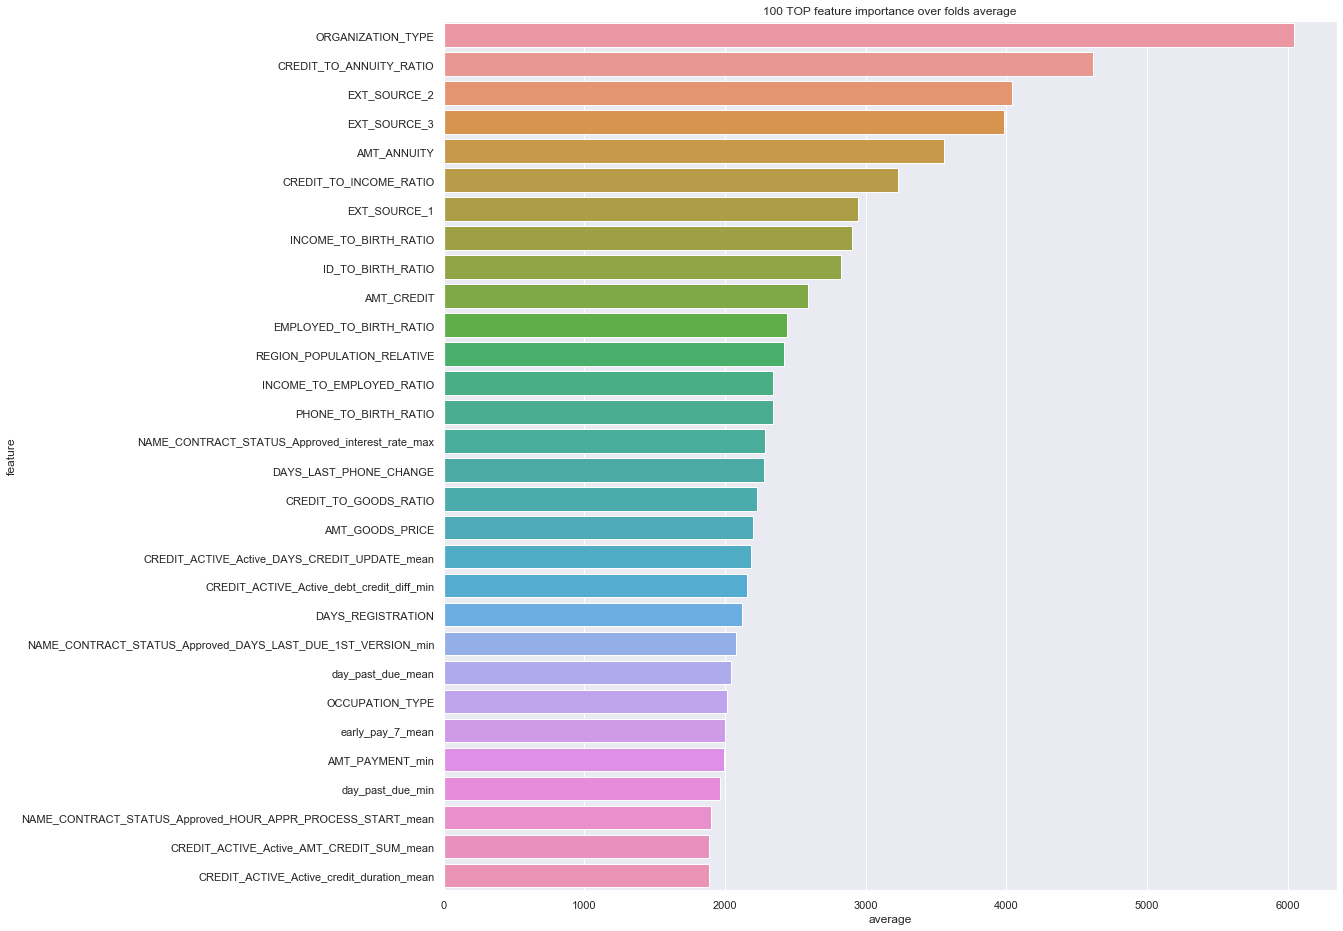

In [53]:
# feature_importances.to_csv('feature_importances.csv')
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(NFOLDS)]].mean(axis=1)
# feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(30), x='average', y='feature');
plt.title('100 TOP feature importance over folds average');





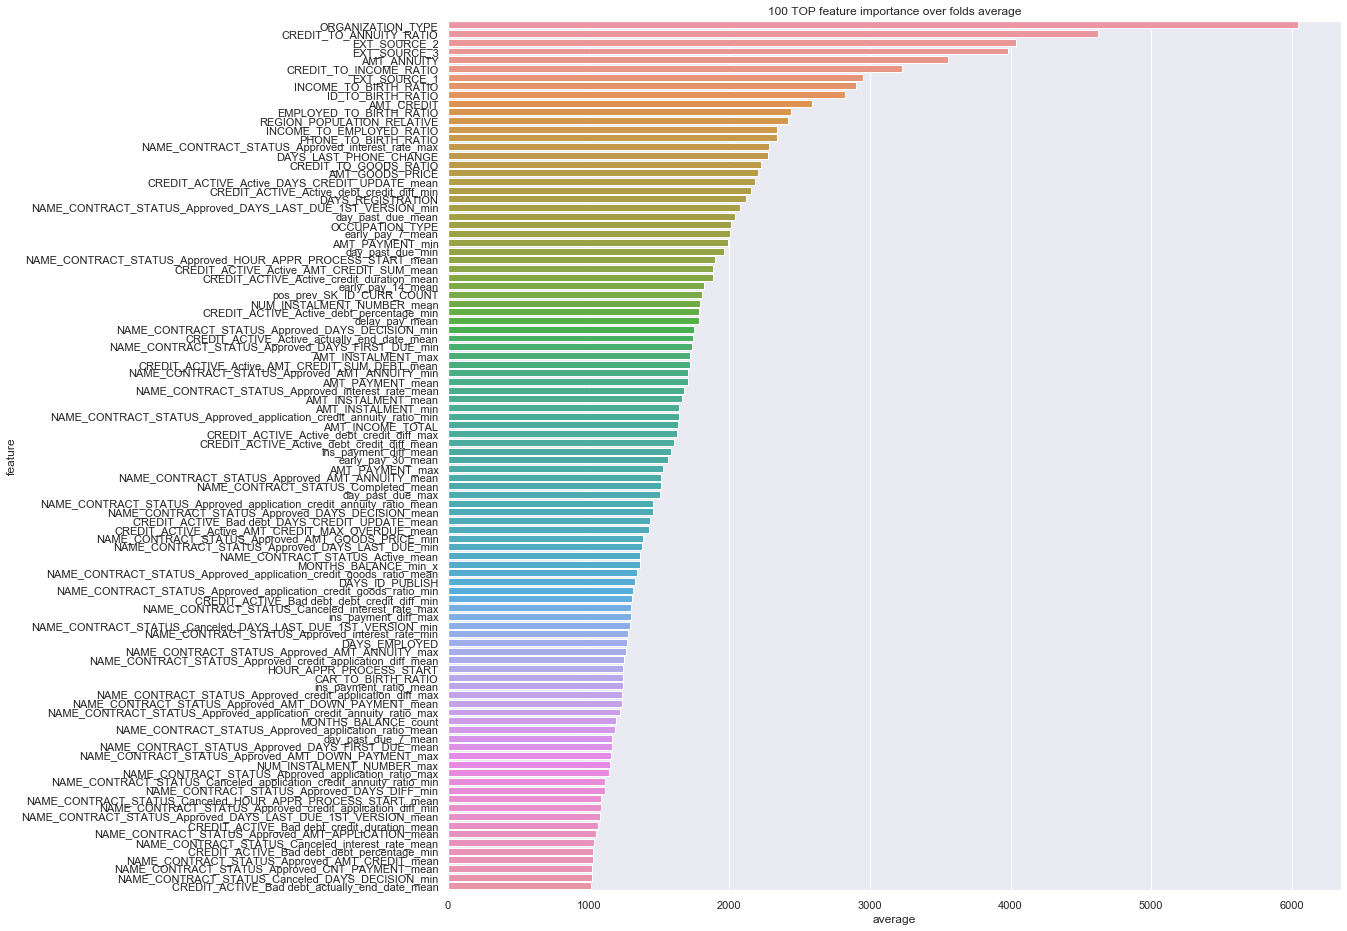

In [54]:
# feature_importances.to_csv('feature_importances.csv')
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(NFOLDS)]].mean(axis=1)
# feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(100), x='average', y='feature');
plt.title('100 TOP feature importance over folds average');




array([[<matplotlib.axes._subplots.AxesSubplot object at 0x132f7d048>]],
      dtype=object)

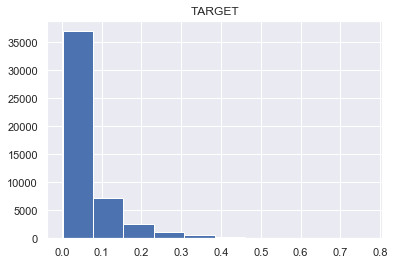

In [55]:
submission = pd.read_csv('./sample_submission.csv')
submission['TARGET'] = predictions

submission.hist('TARGET')


In [56]:
submission.to_csv('./sample_submission_11.csv', index=False)

In [145]:
!pip install shap

     |████████████████████████████████| 273 kB 1.2 MB/s eta 0:00:01
  Created wheel for shap: filename=shap-0.35.0-cp37-cp37m-macosx_10_15_x86_64.whl size=310347 sha256=0c8109cad97cf97ca1811f67b933361d90d29a78a456bdc67afa02e95faf2448
  Stored in directory: /Users/arvis/Library/Caches/pip/wheels/c3/e0/82/26cebc699e23c6a1b9963981e1a10ed7de75db012f4af12428
Successfully built shap
You should consider upgrading via the '/Users/arvis/.pyenv/versions/3.7.0/envs/crawler3.7/bin/python -m pip install --upgrade pip' command.


In [47]:
import shap

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(estimator)



In [89]:
sample = vl_x.sample(n=20000)

In [90]:

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(estimator)
shap_values = explainer.shap_values(vl_x)

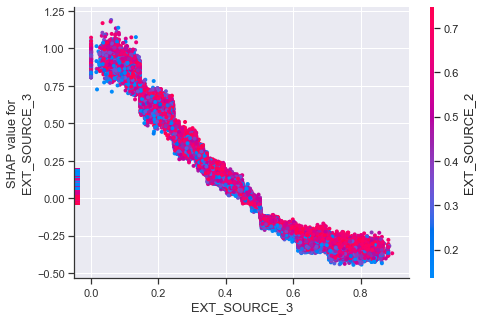

In [91]:
shap.dependence_plot("EXT_SOURCE_3", shap_values[1], vl_x)


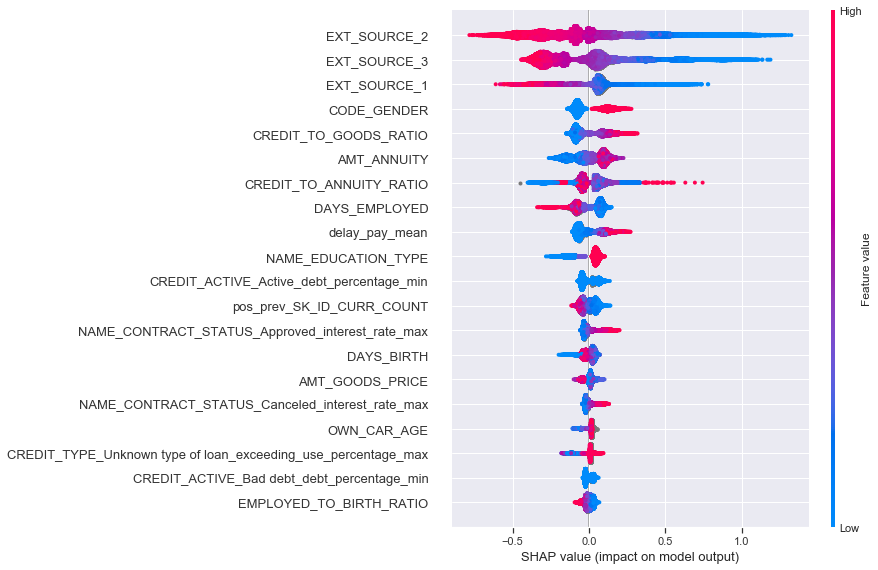

In [92]:
shap.summary_plot(shap_values[1], vl_x)

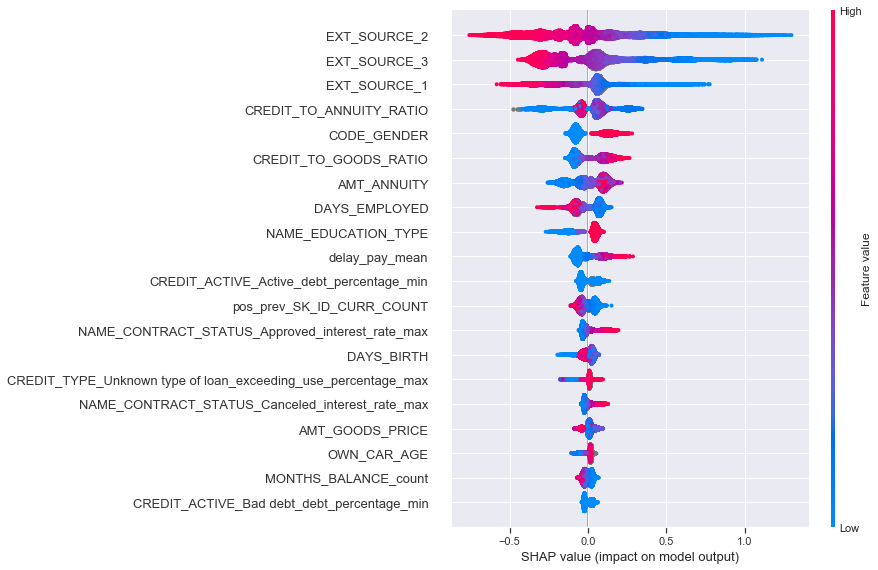

In [84]:
shap.summary_plot(shap_values[1], test_features)

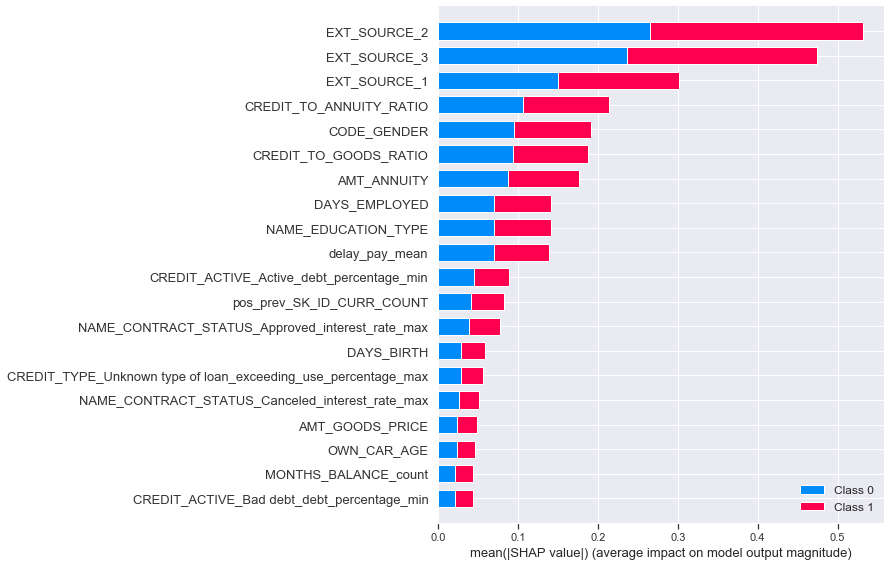

In [82]:
shap.summary_plot(shap_values, test_features)